In [5]:
import torch
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from flashtorch.utils import apply_transforms, load_image
from flashtorch.saliency import Backprop

from model_conv import SimpleCNNSmall_4Layer
import torchvision.models as models
from rule_simulator import RuleSimulatorStats

In [71]:
model = SimpleCNNSmall_4Layer()

base_dir = r"D:\Internship\bimsa\result\predictor_life_simple\2025-11-29_20-04-12_small_4_layer_seq_cnn__200-200-B36_S23"
model.load_state_dict(torch.load(f'{base_dir}\\best_simple_life_SimpleCNNSmall_4Layer_0.1.0.pth', 
                                 map_location=torch.device('cpu'), weights_only=True))

<All keys matched successfully>

In [72]:
rule_stats = RuleSimulatorStats(rule="B36_S23")
rule_stats.load_model(model)
stats_ls = rule_stats.get_transform_stats()

10it [01:16,  7.68s/it]


In [73]:
from collections import Counter

counters = [(Counter(i[1:])) for i in stats_ls]
print(*counters, sep="\n")

Counter({0.0: 23865116, 1.0: 1236996, 3.0: 334792, 2.0: 43091, 4.0: 31975, 5.0: 2})
Counter({2.0: 1200633, 4.0: 130734, 5.0: 110218, 6.0: 25608, 1.0: 8094, 7.0: 5231, 3.0: 2171, 8.0: 778, 0.0: 6})
Counter({3.0: 415931, 4.0: 136571, 5.0: 67766, 6.0: 19778, 0.0: 12274, 2.0: 5154, 7.0: 3191, 8.0: 123, 1.0: 3})
Counter({2.0: 370564, 1.0: 123681, 0.0: 4162, 3.0: 3273, 7.0: 1315, 8.0: 467, 6.0: 302})


[(0.0, 23865116), (1.0, 1236996), (2.0, 43091), (3.0, 334792), (4.0, 31975), (5.0, 2)]
[(0.0, 6), (1.0, 8094), (2.0, 1200633), (3.0, 2171), (4.0, 130734), (5.0, 110218), (6.0, 25608), (7.0, 5231), (8.0, 778)]
[(0.0, 12274), (1.0, 3), (2.0, 5154), (3.0, 415931), (4.0, 136571), (5.0, 67766), (6.0, 19778), (7.0, 3191), (8.0, 123)]
[(0.0, 4162), (1.0, 123681), (2.0, 370564), (3.0, 3273), (6.0, 302), (7.0, 1315), (8.0, 467)]


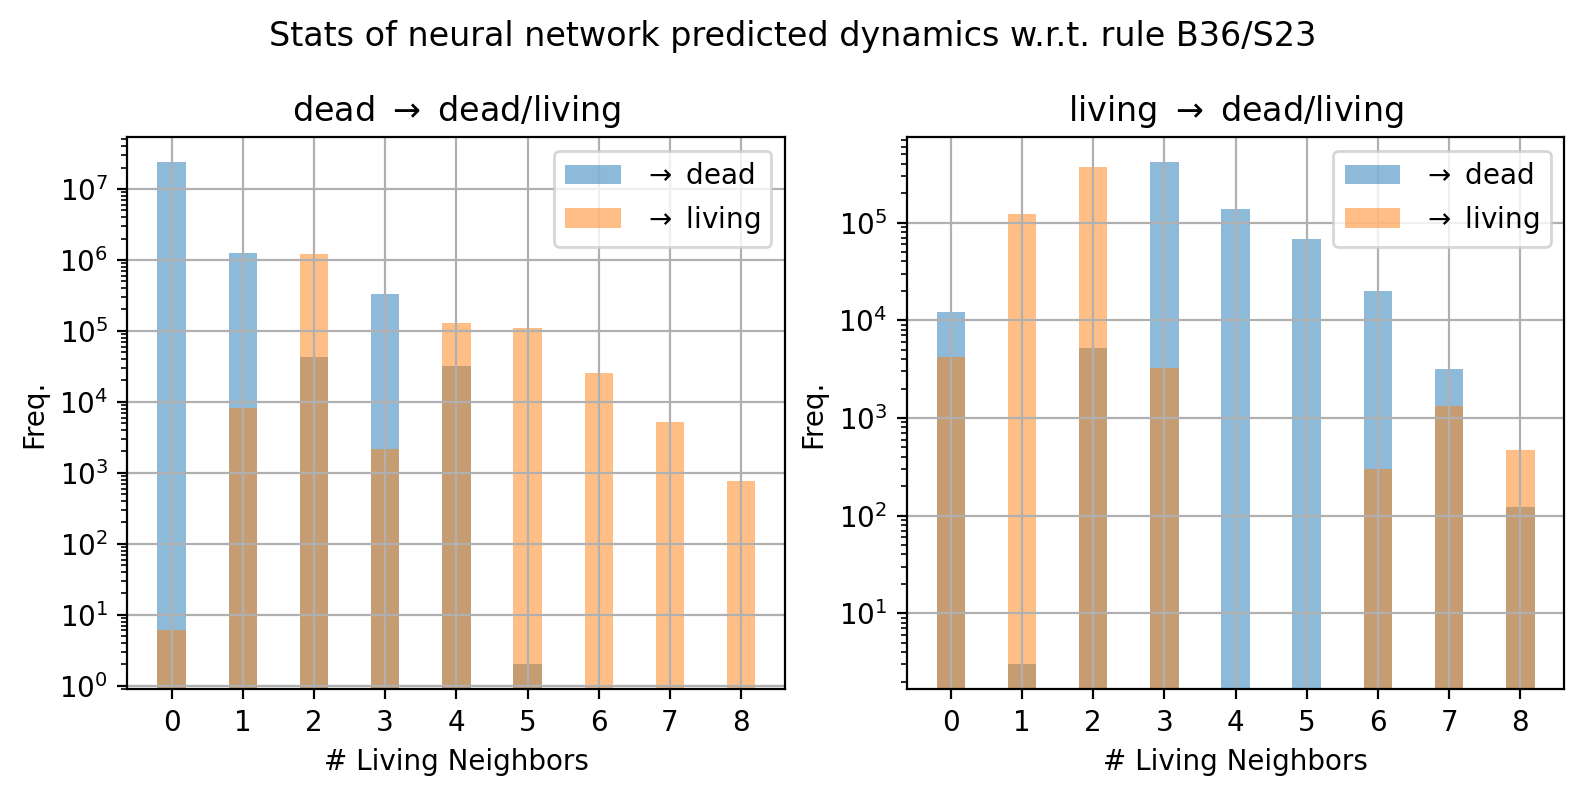

In [74]:
stats = []
titles = ["dead $\\rightarrow$ dead/living",
                  "living $\\rightarrow$ dead/living"]
        
for counter in counters:
    items = sorted(list(counter.items()), key=lambda x:x[0])
    print(items)
    
    x = list(range(9))
    y = [counter.get(i, 0) for i in x]
    stats.append((x,y))

plt.figure(dpi=200, figsize=(8, 4))

plt.suptitle(f"Stats of neural network predicted dynamics w.r.t. rule B36/S23")

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.bar(*stats[2*i], width=0.4, align="center", label="$\\rightarrow$ dead", alpha=0.5)
    plt.bar(*stats[2*i+1], width=0.4, align="center", label="$\\rightarrow$ living", alpha=0.5)
    plt.xticks(range(9), range(9))
    plt.xlabel("# Living Neighbors")
    plt.ylabel("Freq.")
    plt.semilogy()
    plt.grid()
    plt.legend()
    plt.title(titles[i])

plt.tight_layout(pad=1, h_pad=0.5, w_pad=0.5)

In [75]:
dd, dl = sum(counters[0].values()), sum(counters[1].values())
ld, ll = sum(counters[2].values()), sum(counters[3].values())

In [76]:
acc = 0.99

In [77]:
d_th = (1-acc)*(dd+dl)
l_th = (1-acc)*(ld+ll)
d_th, l_th

(269954.45000000024, 11645.55000000001)

In [78]:
d_all = counters[0] + counters[1]
l_all = counters[2] + counters[3]

In [79]:
filtered_b = sorted(list(filter(lambda x:x[1]>0.9*d_th, d_all.items())), key=lambda x:x[0])
filtered_s = sorted(list(filter(lambda x:x[1]>0.9*l_th, l_all.items())), key=lambda x:x[0])

In [84]:
born = []
survive = []

for i,j in filtered_b:
    if counters[1][i] > counters[0][i]:
        born.append(str(int(i)))

for i,j in filtered_s:
    if counters[3][i] > counters[2][i]:
        survive.append(str(int(i)))

born, survive

(['2'], ['1', '2'])

In [87]:
''.join(born), ''.join(survive)

('2', '12')

In [88]:
def join_dicts(d1, d2):
    # 获取两个字典的所有键，并去重
    all_keys = set(d1.keys()).union(d2.keys())
    # 创建结果字典
    join_d = {}
    # 遍历所有键
    for key in all_keys:
        # 获取每个键在两个字典中的值，若不存在则为0
        value1 = d1.get(key, 0)
        value2 = d2.get(key, 0)
        # 将结果存入新字典
        join_d[key] = (value1, value2)
    return join_d

In [89]:
join_dicts(counters[0], counters[1])

{0.0: (23865116, 6),
 1.0: (1236996, 8094),
 2.0: (43091, 1200633),
 3.0: (334792, 2171),
 4.0: (31975, 130734),
 5.0: (2, 110218),
 6.0: (0, 25608),
 7.0: (0, 5231),
 8.0: (0, 778)}

In [100]:
import numpy as np

np.printoptions(precision=3)
list(map(lambda x:(x[0], (round((x[1][0]+1)/(x[1][0]+x[1][1]+2), 3), 
                          round((x[1][1]+1)/(x[1][0]+x[1][1]+2), 3))), join_dicts(counters[0], counters[1]).items()))

[(0.0, (1.0, 0.0)),
 (1.0, (0.993, 0.007)),
 (2.0, (0.035, 0.965)),
 (3.0, (0.994, 0.006)),
 (4.0, (0.197, 0.803)),
 (5.0, (0.0, 1.0)),
 (6.0, (0.0, 1.0)),
 (7.0, (0.0, 1.0)),
 (8.0, (0.001, 0.999))]